# TD3

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import logging
l = logging.getLogger()
l.setLevel(logging.DEBUG)

In [3]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import pickle
import gc
import json
import h5py

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

# comment out if you are not using themes
from jupyterthemes import jtplot
jtplot.style(theme='grade3')

# == recnn ==
import sys
sys.path.append("../../")
import recnn

cuda = torch.device('cuda')

# ---
frame_size = 10
batch_size = 25
n_epochs   = 100
plot_every = 30
step       = 0
# --- 

tqdm.pandas()

In [4]:
env = recnn.env.FrameEnv('../../data/embeddings/ml20_pca128.pkl',
                         '../../data/ml-20m/ratings.csv', frame_size, batch_size)

In [6]:
def soft_update(net, target_net, soft_tau=1e-2):
    for target_param, param in zip(target_net.parameters(), net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )
            
def run_tests():
    test_batch = next(iter(env.test_dataloader))
    losses = td3_update(step, test_batch, params, learn=False)
    
    gen_actions = debugger.debug_dict['mat']['gen_action']
    gen_test_actions = debugger.debug_dict['mat']['test gen_action']
    true_actions = env.embeddings.detach().cpu().numpy()
    
    f = plotter.kde_reconstruction_error(ad, gen_actions, gen_test_actions, true_actions, cuda)
    writer.add_figure('rec_error',f, losses['step'])
    return losses

In [7]:
def td3_update(step, batch, params, learn=True):
    
    batch = [i.to(cuda) for i in batch]
    state, action, reward, next_state, done = batch
    
    # --------------------------------------------------------#
    # Value Learning
    
    reward     = reward.unsqueeze(1)
    done       = done.unsqueeze(1)
    
    next_action = target_policy_net(next_state)
    noise = torch.normal(torch.zeros(next_action.size()),
                         params['noise_std']).to(cuda)
    noise = torch.clamp(noise, -params['noise_clip'], params['noise_clip'])
    next_action += noise
    
    with torch.no_grad():
        target_q_value1  = target_value_net1(next_state, next_action)
        target_q_value2  = target_value_net2(next_state, next_action)
        target_q_value   = torch.min(target_q_value1, target_q_value2)
        expected_q_value = reward + (1.0 - done) * params['gamma'] * target_q_value
    
    q_value1 = value_net1(state, action)
    q_value2 = value_net2(state, action)

    value_loss1 = value_criterion(q_value1, expected_q_value.detach())
    value_loss2 = value_criterion(q_value2, expected_q_value.detach())
    
    debugger.log_error('value1', q_value1)
    debugger.log_error('value2', q_value2)
    debugger.log_error('next_action', next_action)
    debugger.log_error('target_value ', target_q_value)
    
    if learn:
        value_optimizer1.zero_grad()
        value_loss1.backward()
        value_optimizer1.step()

        value_optimizer2.zero_grad()
        value_loss2.backward()
        value_optimizer2.step()
    else:
        writer.add_figure('next_action',
                    recnn.plot.pairwise_distances_fig(next_action[:50]), step)
        writer.add_histogram('value1', q_value1, step)
        writer.add_histogram('value2', q_value2, step)
        writer.add_histogram('target_value', target_q_value, step)
        writer.add_histogram('expected_value', expected_q_value, step)

    # --------------------------------------------------------#
    # Policy learning

    gen_action = policy_net(state)
    policy_loss = value_net1(state, gen_action)
    policy_loss = -policy_loss
    
    if learn:
        debugger.log_object('gen_action', gen_action,  "mat")
        
    else: 
        debugger.log_object('test gen_action', gen_action, "mat")
        writer.add_figure('gen_action',
                    recnn.plot.pairwise_distances_fig(gen_action[:50]), step)
        writer.add_histogram('policy_loss', policy_loss, step)
        
    policy_loss = policy_loss.mean()
    
    # delayed policy update
    if step % params['policy_update'] == 0 and learn:
        policy_optimizer.zero_grad()
        policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(policy_net.parameters(), -1, 1)
        policy_optimizer.step()

        soft_update(value_net1, target_value_net1, soft_tau=params['soft_tau'])
        soft_update(value_net2, target_value_net2, soft_tau=params['soft_tau'])
    
    losses = {'value1': value_loss1.item(),
              'value2': value_loss2.item(),
              'policy': policy_loss.item(),
              'step'  : step}
    return losses

In [8]:
# === TD3 settings ===
params = {
    'gamma': 0.99,
    'noise_std': 0.5,
    'noise_clip': 3,
    'soft_tau': 0.001,
    'policy_update': 10,
    
    'policy_lr': 1e-5,
    'value_lr': 1e-5,
    
    'actor_weight_init': 25e-2,
    'critic_weight_init': 6e-1,
}
# === end ===

In [12]:
value_net1  = recnn.models.Critic(1290, 128, 256, params['critic_weight_init']).to(cuda)
value_net2 = recnn.models.Critic(1290, 128, 256, params['critic_weight_init']).to(cuda)
policy_net = recnn.models.Actor(1290, 128, 256, params['actor_weight_init']).to(cuda)

target_value_net1 = recnn.models.Critic(1290, 128, 256).to(cuda)
target_value_net2 = recnn.models.Critic(1290, 128, 256).to(cuda)
target_policy_net = recnn.models.Actor(1290, 128, 256).to(cuda)

soft_update(value_net1, target_value_net1, soft_tau=1.0)
soft_update(value_net2, target_value_net2, soft_tau=1.0)
soft_update(policy_net, target_policy_net, soft_tau=1.0)

In [13]:
value_criterion = nn.MSELoss()

value_optimizer1 = recnn.optim.Ranger(value_net1.parameters(), lr=params['value_lr'],  weight_decay=1e-2)
value_optimizer2 = recnn.optim.Ranger(value_net2.parameters(), lr=params['value_lr'],  weight_decay=1e-2)
policy_optimizer = recnn.optim.Ranger(policy_net.parameters(), lr=params['policy_lr'], weight_decay=1e-5)

ad = recnn.models.AnomalyDetector().to(cuda)
ad.load_state_dict(torch.load('../../models/anomaly.pt'))
ad.eval()


layout = {
    'train': {'value1': [], 'value2': [], 'policy': [], 'step': []},
    'test': {'value1': [], 'value2': [], 'policy': [], 'step': []}
    }

writer = SummaryWriter(log_dir='../../runs')
debugger = recnn.Debugger(layout, run_tests, writer)
plotter = recnn.Plotter(debugger, [['value1', 'policy']],)

step 90


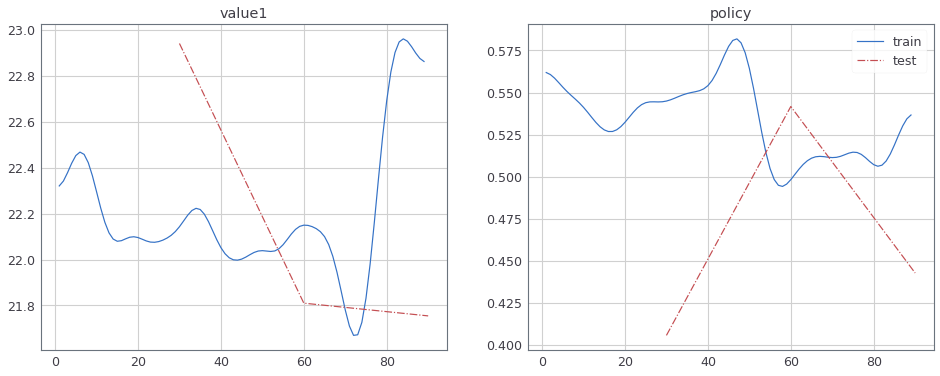

KeyboardInterrupt: 

In [15]:
for epoch in range(n_epochs):
    epoch_bar.update(1)
    for batch in tqdm(env.train_dataloader):
        loss = td3_update(step, batch, params)
        debugger.log_losses(loss)
        step += 1
        debugger.log_step(step)
        if step % plot_every == 0:
            clear_output(True)
            print('step', step)
            debugger.test()
            plotter.plot_loss()

In [65]:
torch.save(value_net1.state_dict(), "../../models/td3_value.pt")
torch.save(policy_net.state_dict(), "../../models/td3_policy.pt")

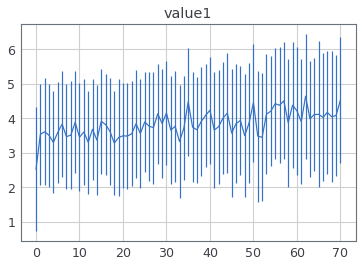

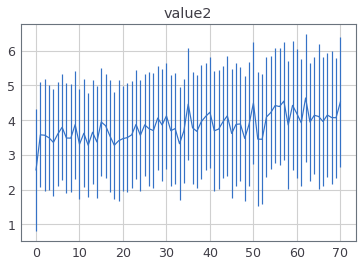

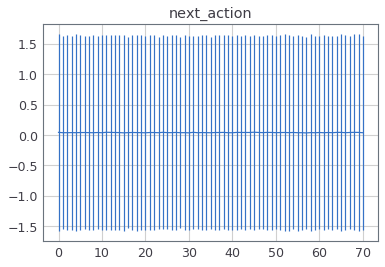

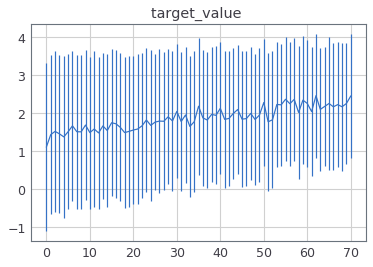

In [66]:
debugger.err_plot()

../../recnn/plot.py:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


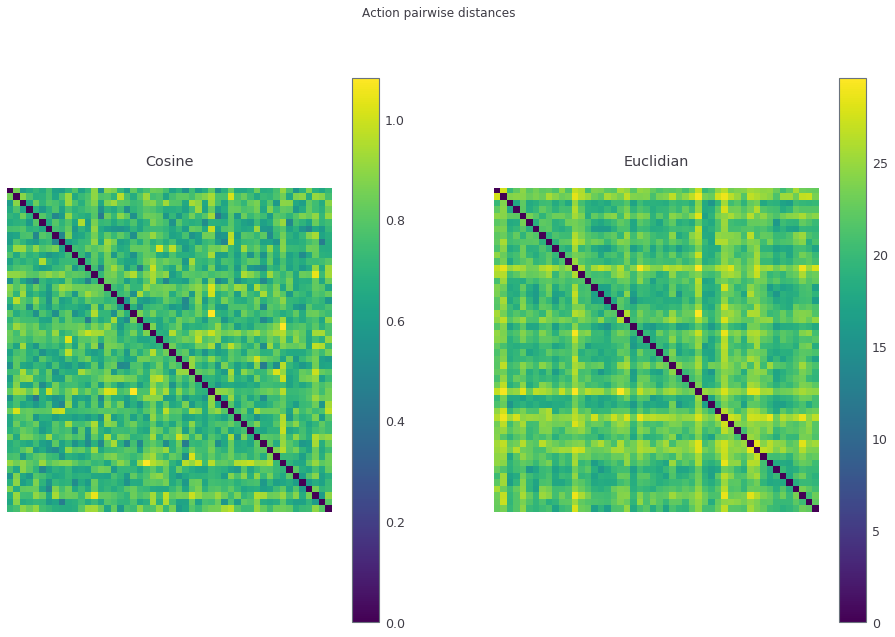

In [67]:
debugger.matshow('gen_action')

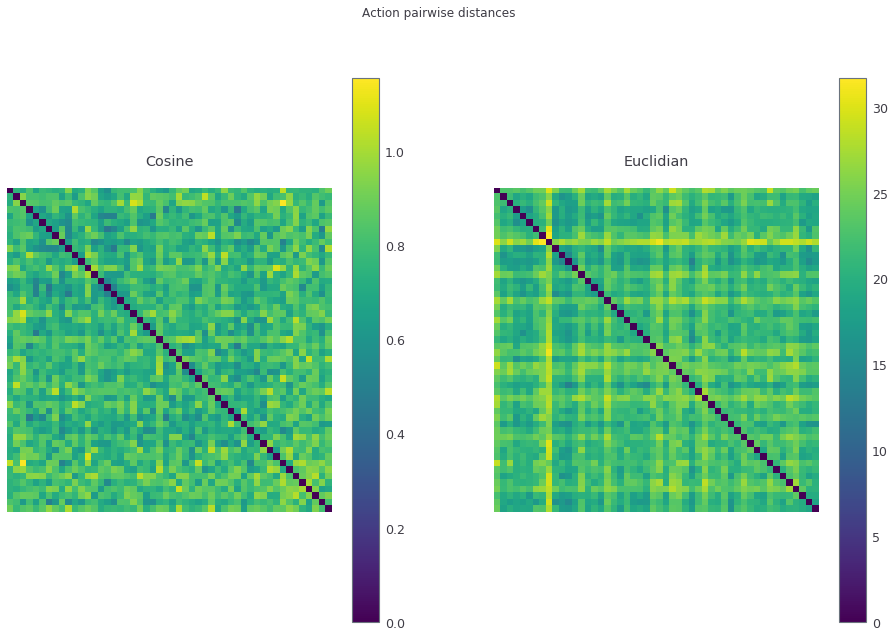

In [68]:
debugger.matshow('test gen_action')

/home/dev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
../../recnn/debugger.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gen_scores = ad.rec_error(torch.tensor(gen_actions).to(device).float()).detach().cpu().numpy()
../../recnn/debugger.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gen_test_scores = ad.rec_error(torch.tensor(gen_test_actions).to(device).float()).de

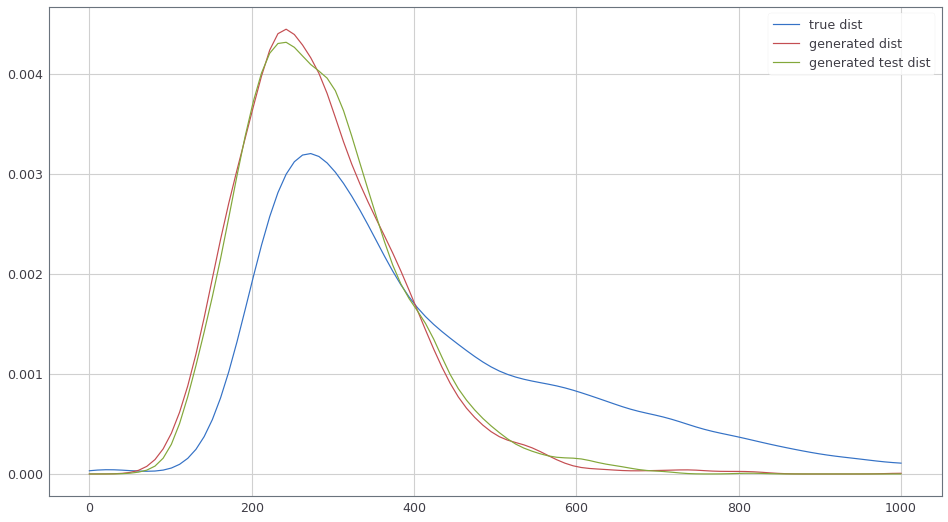

In [70]:
gen_actions = debugger.debug_dict['mat']['gen_action']
gen_test_actions = debugger.debug_dict['mat']['test gen_action']
true_actions = np.stack(movie_embeddings_key_dict.values())
    
ad = recnn.models.AnomalyDetector().to(cuda)
ad.load_state_dict(torch.load('../../models/anomaly.pt'))
ad.eval()

debugger.plot_kde_reconstruction_error(ad, gen_actions, gen_test_actions, true_actions, cuda)